This notebook shows how to solve the problem as a multi-class classification by finding candidate points based on geographic location.<br>
Similarity as a string, such as edit distance and LCS (Longest Common Subsequence), was used for the features of the candidate points.<br>
<br>
Inference is made on test data only, but the code for training is left commented out.<br>
<br>
In addition, making the matches bidirectional as a post-processing step improved the score by about 1%.<br>
<br>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import gc
import random
from glob import glob
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
import warnings
import seaborn as sns
import pickle
import json
import re
import time
import sys
from requests import get
import multiprocessing
import joblib
from collections import Counter, defaultdict
if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1

class CFG:
    seed = 46
    target = "point_of_interest"
    n_neighbors = 10
    n_splits = 3
    debug = False
    save = False
    country_num = 10

    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]

random.seed(CFG.seed)
os.environ["PYTHONHASHSEED"] = str(CFG.seed)
np.random.seed(CFG.seed)

plt.rcParams["font.size"] = 13
warnings.filterwarnings('ignore')

%cd /content/drive/MyDrive/Kaggle/Foursquare/Notebook

Found existing installation: lightgbm 2.2.3
Uninstalling lightgbm-2.2.3:
  Successfully uninstalled lightgbm-2.2.3
     |████████████████████████████████| 2.0 MB 4.1 MB/s 
/content/drive/MyDrive/Kaggle/Foursquare/Notebook


In [3]:
OUTPUT_DIR = '../Output'
if not os.path.exists(os.path.join(OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(OUTPUT_DIR, CFG.expID))

In [4]:
train = pd.read_csv("../Input/train.csv")
test = pd.read_csv("../Input/test.csv")
test[CFG.target] = "TEST"

train.head(1)

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e


In [5]:
if CFG.debug:
    train = train[:10000]

In [6]:
countries = train['country'].value_counts()
major_countries = countries[countries > CFG.country_num].index
major_countries

Index(['US', 'TR', 'ID', 'JP', 'TH', 'RU', 'BR', 'MY', 'BE', 'GB',
       ...
       'CM', 'AG', 'MW', 'VC', 'VA', 'RW', 'DM', 'CV', 'SX', 'CD'],
      dtype='object', length=176)

In [7]:
mean_latlon = train[train['country'].isin(major_countries)].groupby('country')[['latitude', 'longitude']].mean().apply(lambda x: tuple(x), axis = 1).to_dict()
mean_latlon

{'AD': (42.545859185636466, 1.5623949169263895),
 'AE': (25.031196156825867, 55.125843416026626),
 'AF': (33.83802625734884, 66.24355789971725),
 'AG': (17.064483743894495, -61.8103130873108),
 'AL': (41.16438043034689, 19.412328749941274),
 'AM': (40.226330254579786, 44.639090877452354),
 'AO': (-8.889374849019317, 13.202976589291133),
 'AQ': (-69.60762211178053, -13.85584018293251),
 'AR': (-34.3017973185889, -59.675176940818325),
 'AT': (47.82784149912836, 14.668674401181589),
 'AU': (-33.60605387334255, 145.81505022396252),
 'AW': (12.538799105310463, -70.0247308418892),
 'AX': (59.189586941545805, 18.925737862902142),
 'AZ': (40.3754732198509, 49.74492239537704),
 'BA': (43.94847201899628, 18.204256543029196),
 'BB': (13.108549846295455, -59.59389100581457),
 'BD': (23.832095040888664, 89.78014903512299),
 'BE': (50.98628567649715, 4.058717644388699),
 'BG': (42.641392575674466, 24.688713330227394),
 'BH': (26.24331108929355, 50.43609293011559),
 'BL': (17.904371494236624, -62.841

In [8]:
!pip install haversine
from haversine import haversine, Unit

In [ ]:
def correct_country(latlon):
    min_distance = float('inf')
    min_country = None
    for country in major_countries:
        distance = haversine(latlon, mean_latlon[country])
        if distance < min_distance:
            min_distance = distance
            min_country = country
    return min_country
train['new_country'] = train[['latitude', 'longitude']].apply(correct_country, axis = 1)
test['new_country'] = test[['latitude', 'longitude']].apply(correct_country, axis = 1)
print('Concordance rate: ' + str((train['country'] == train['new_country']).mean()))
train.head()

Concordance rate: 0.7032521610239443


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,new_country
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e,BE
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83,BR
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477,TH
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3,TR
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb,ES


# Devide Train Data into about 600K×2

In [ ]:
kf = GroupKFold(n_splits=2)
for i, (trn_idx, val_idx) in enumerate(kf.split(train, train[CFG.target], train[CFG.target])):
    train.loc[val_idx, "set"] = i
train["set"].value_counts()

1.0    569406
0.0    569406
Name: set, dtype: int64

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

def add_neighbor_features(df):
    dfs = []
    columns = ['id', 'name', 'address', 'city', 'state',
           'zip', 'new_country', 'url', 'phone', 'categories']
    for c in columns:
        if c != "id":
            df[c] = df[c].astype(str).str.lower()

    for country, country_df in tqdm(df.groupby("new_country")):
        country_dfs = []
        country_df = country_df.reset_index(drop=True)
        
        knn = KNeighborsRegressor(n_neighbors=min(len(country_df), CFG.n_neighbors), 
                                  metric='haversine', n_jobs=-1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude','longitude']], return_distance=True)
        targets = country_df[CFG.target].values
        for i in range(min(len(country_df), CFG.n_neighbors)):
            country_df_ = country_df.copy()
            country_df_[f"d_near"] = dists[:, i]
            country_df_[f"near_target"] = targets[nears[:, i]]
            for c in columns:
                country_df_[f"near_{c}"] = country_df_[c].values[nears[:, i]]
            country_dfs.append(country_df_)
        country_df = pd.concat(country_dfs)
        dfs.append(country_df)
    df = pd.concat(dfs).reset_index(drop=True)
    return df

train = pd.concat([
    add_neighbor_features(train[train["set"]==0]), 
    add_neighbor_features(train[train["set"]==1]), 
])
test = add_neighbor_features(test)

train.head(1)

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_id,near_name,near_address,near_city,near_state,near_zip,near_new_country,near_url,near_phone,near_categories
0,E_0014dae22ccd6b,shôko restaurant,41.385287,2.197004,"pg. marítim de la barceloneta, 38",barcelona,nan,nan,ES,nan,...,E_0014dae22ccd6b,shôko restaurant,"pg. marítim de la barceloneta, 38",barcelona,nan,nan,ad,nan,nan,japanese restaurants


In [ ]:
train = train[train['id'] != train['near_id']]
test = test[test['id'] != test['near_id']]

# Create Target

In [ ]:
train["target"] = 0
train.loc[train[CFG.target]==train[f"near_target"], "target"] = 1
train.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_name,near_address,near_city,near_state,near_zip,near_new_country,near_url,near_phone,near_categories,target
363,E_1c42297fda9e48,beverage station,44.752732,-1.086829,nan,nan,nan,33510,FR,nan,...,the beverage station,nan,nan,nan,33510,ad,nan,nan,fast food restaurants,1
373,E_1d31342d2e5805,estación de servicio cepsa,43.284564,-2.265653,barrio narrondo,zumaia,gipuzkoa,20750,ES,https://cercadeti.cepsa.es/6114-estacion-de-se...,...,estación de servicio cepsa,barrio narrondo,zumaia,gipuzkoa,20750,ad,https://cercadeti.cepsa.es/530-estacion-de-ser...,+34943861082,nan,1
642,E_34e1bc94cd94d3,rent a car saint jean de luz,43.406270,-1.616368,zi de jalday,saint jean de luz,aquitaine-limousin-poitou-charentes,64500,FR,https://www.rentacar.fr/agences/391-saint-jean...,...,rent a car saint jean de luz,zi de jalday,saint jean de luz,nan,64500,ad,https://www.rentacar.fr/agences/391-saint-jean...,+33559507060,rental car locations,1
719,E_3bdf0c22354e57,taverna ongi etorriak,41.346620,1.696817,carrer sant bernat,vilafranca del penedes,barcelona,08720,ES,nan,...,ongi etorriak,"c. de sant bernat, 4",vilafranca del penedes,barcelona,08720,ad,nan,938904354,tapas restaurants,1
730,E_3cb8475424e07f,obaibi,43.607900,1.394600,36/54 rte de bayonne,toulouse,france,31 000,FR,nan,...,okaidi-obaibi,36/54 rte de bayonne,toulouse,france,31 000,ad,nan,nan,"kids stores, arcades",1


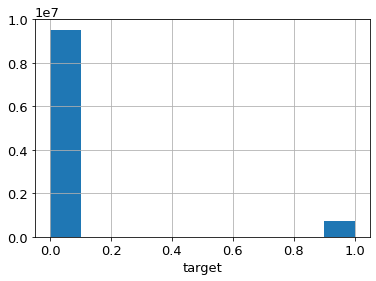

In [ ]:
plt.hist(train["target"])
plt.grid()
plt.xlabel("target")
plt.show()

# Check Maximum Score

In [ ]:
# https://www.kaggle.com/code/columbia2131/foursquare-iou-metrics
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

id2poi = get_id2poi(train)
poi2ids = get_poi2ids(train)

In [ ]:
def get_score(id2ids: dict):
    scores = []
    precisions = []
    recalls = []
    for id_str in train['id'].unique():
        if id_str in id2ids:
            preds = id2ids[id_str]
        else:
            preds = set()
        preds.add(id_str)
        targets = poi2ids[id2poi[id_str]]
        score = len((targets & preds)) / len((targets | preds))
        if len(preds) == 0:
            precision = 0
        else:
            precision = len((targets & preds)) / len(preds)
        recall = len((targets & preds)) / len(targets)
        scores.append(score)
        precisions.append(precision)
        recalls.append(recall)
    scores = np.array(scores)
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    return scores.mean(), precisions.mean(), recalls.mean()

In [ ]:
id2ids = train[train[CFG.target] == train['near_target']].groupby('id')['near_id'].apply(lambda x: set(x))
score, precision, recall = get_score(id2ids)
print(score)

0.8929518335714638


In [ ]:
# del train
# gc.collect()

# Feature Engineering

In [ ]:
if "google.colab" in sys.modules:
    !pip install Levenshtein

     |████████████████████████████████| 258 kB 4.2 MB/s 
     |████████████████████████████████| 1.8 MB 73.3 MB/s 
     |████████████████████████████████| 103 kB 65.5 MB/s 


In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
import Levenshtein
import difflib

def _add_distance_features(args):
    _, df = args

    columns = ['name', 'address', 'city', 'state',
           'zip', 'new_country', 'url', 'phone', 'categories']

    for c in columns:
        geshs = []
        levens = []
        jaros = []
        lcss = []
        for str1, str2 in df[[c, f"near_{c}"]].values.astype(str):
            if str1==str1 and str2==str2:
                geshs.append(difflib.SequenceMatcher(None, str1, str2).ratio())
                levens.append(Levenshtein.distance(str1, str2))
                jaros.append(Levenshtein.jaro_winkler(str1, str2))
                lcss.append(LCS(str(str1), str(str2)))
            else:
                geshs.append(-1)
                levens.append(-1)
                jaros.append(-1)
        df[f"near_{c}_gesh"] = geshs
        df[f"near_{c}_leven"] = levens
        df[f"near_{c}_jaro"] = jaros
        df[f"near_{c}_lcs"] = lcss
        
        if not c in ['new_country', "phone", "zip"]:
            df[f"{c}_len"] = df[c].astype(str).map(len)
            df[f"near_{c}_len"] = df[f"near_{c}"].astype(str).map(len)
            df[f"near_{c}_nleven"] = df[f"near_{c}_leven"] / df[[f"near_{c}_len", f"{c}_len"]].max(axis=1)
            df[f"near_{c}_nlcsi"] = df[f"near_{c}_lcs"] / df[f"near_{c}_len"]
            df[f"near_{c}_nlcs0"] = df[f"near_{c}_lcs"] / df[f"{c}_len"]
    return df

def add_distance_features(df):
    processes = multiprocessing.cpu_count()
    with multiprocessing.Pool(processes=processes) as pool:
        dfs = pool.imap_unordered(_add_distance_features, df.groupby('new_country'))
        dfs = tqdm(dfs)
        dfs = list(dfs)
    df = pd.concat(dfs)
    return df

train_distance_features_path = os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "train_distance_features.csv"))
test_distance_features_path = os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "test_distance_features.csv"))

if CFG.save and (os.path.exists(train_distance_features_path) and os.path.exists(test_distance_features_path)):
    train = pd.read_csv(train_distance_features_path)
    test = pd.read_csv(test_distance_features_path)
else:
    train = add_distance_features(train)
    test = add_distance_features(test)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
display(train.head(1))
display(test.head(1))

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_phone_lcs,near_categories_gesh,near_categories_leven,near_categories_jaro,near_categories_lcs,categories_len,near_categories_len,near_categories_nleven,near_categories_nlcsi,near_categories_nlcs0
50768,E_02ef4d9ef8aa33,beach,17.085518,-61.893896,hermitage bay,st. john's,parish of saint john,nan,AG,nan,...,3,0.166667,15,0.30112,2,7,17,0.882353,0.117647,0.285714


,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_phone_lcs,near_categories_gesh,near_categories_leven,near_categories_jaro,near_categories_lcs,categories_len,near_categories_len,near_categories_nleven,near_categories_nlcsi,near_categories_nlcs0
4,E_001b6bad66eb98,"gelora sriwijaya, jaka baring sport city",-3.014675,104.794374,nan,nan,nan,nan,ID,nan,...,3,0.695652,7,0.461111,8,8,15,0.466667,0.533333,1.0


In [ ]:
if CFG.save and not (os.path.exists(train_distance_features_path) and os.path.exists(test_distance_features_path)):
    train.to_csv(train_distance_features_path, index=False)
    test.to_csv(test_distance_features_path, index=False)

# Delete Unusing Columns (just for avoiding OOM)

In [ ]:
train['new_country_pair'] = train[['new_country', 'near_new_country']].apply(lambda x: tuple(sorted(list(x))), axis = 1)
test['new_country_pair'] = test[['new_country', 'near_new_country']].apply(lambda x: tuple(sorted(list(x))), axis = 1)

In [ ]:
features = []

columns = ['name', 'address', 'city', 'state',
       'zip', 'new_country', 'url', 'phone', 'categories']

features.append(f"d_near")
for c in columns:        
    features += [f"near_{c}_gesh", f"near_{c}_jaro", f"near_{c}_lcs"]
    if c in ['new_country', "phone", "zip"]:
        features += [f"near_{c}_leven"]
    else:
        features += [f"near_{c}_len", f"near_{c}_nleven", f"near_{c}_nlcsi", f"near_{c}_nlcs0"]

for f in features:
#     assert f in train.columns
    if f not in test.columns:
        test[f] = np.nan

print(features)

['d_near', 'near_name_gesh', 'near_name_jaro', 'near_name_lcs', 'near_name_len', 'near_name_nleven', 'near_name_nlcsi', 'near_name_nlcs0', 'near_address_gesh', 'near_address_jaro', 'near_address_lcs', 'near_address_len', 'near_address_nleven', 'near_address_nlcsi', 'near_address_nlcs0', 'near_city_gesh', 'near_city_jaro', 'near_city_lcs', 'near_city_len', 'near_city_nleven', 'near_city_nlcsi', 'near_city_nlcs0', 'near_state_gesh', 'near_state_jaro', 'near_state_lcs', 'near_state_len', 'near_state_nleven', 'near_state_nlcsi', 'near_state_nlcs0', 'near_zip_gesh', 'near_zip_jaro', 'near_zip_lcs', 'near_zip_leven', 'near_new_country_gesh', 'near_new_country_jaro', 'near_new_country_lcs', 'near_new_country_leven', 'near_url_gesh', 'near_url_jaro', 'near_url_lcs', 'near_url_len', 'near_url_nleven', 'near_url_nlcsi', 'near_url_nlcs0', 'near_phone_gesh', 'near_phone_jaro', 'near_phone_lcs', 'near_phone_leven', 'near_categories_gesh', 'near_categories_jaro', 'near_categories_lcs', 'near_categor

In [ ]:
train = train[features + [CFG.target, "target", "id", "near_id", "new_country_pair"]]
test = test[features + ["id", "near_id", "new_country_pair"]]

train[features] = train[features].astype(np.float16)
test[features] = test[features].astype(np.float16)

train["target"] = train["target"].fillna(0)

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

for _ in range(5):
    gc.collect()

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10250452 entries, 0 to 10250451
Data columns (total 60 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   d_near                  float16
 1   near_name_gesh          float16
 2   near_name_jaro          float16
 3   near_name_lcs           float16
 4   near_name_len           float16
 5   near_name_nleven        float16
 6   near_name_nlcsi         float16
 7   near_name_nlcs0         float16
 8   near_address_gesh       float16
 9   near_address_jaro       float16
 10  near_address_lcs        float16
 11  near_address_len        float16
 12  near_address_nleven     float16
 13  near_address_nlcsi      float16
 14  near_address_nlcs0      float16
 15  near_city_gesh          float16
 16  near_city_jaro          float16
 17  near_city_lcs           float16
 18  near_city_len           float16
 19  near_city_nleven        float16
 20  near_city_nlcsi         float16
 21  near_city_nlcs0         float

# Split Folds

In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [ ]:
def get_distribution(y_vals):
        y_distr = Counter(y_vals)
        y_vals_sum = sum(y_distr.values())
        return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [ ]:
distrs = [get_distribution(train["target"])]
index = ['training set']

for fold_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(train, train["target"], train["new_country_pair"], k=CFG.n_splits, seed=CFG.seed)):
    train.loc[val_ind, "fold"] = fold_ind

    dev_y, val_y = train.loc[dev_ind, "target"], train.loc[val_ind, "target"]
    dev_groups, val_groups = train.loc[dev_ind, "new_country_pair"], train.loc[val_ind, "new_country_pair"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - fold {fold_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - fold {fold_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(train["target"]) + 1)])

'Distribution per class:'

,Label 0,Label 1
training set,92.95%,7.05%
development set - fold 0,92.97%,7.03%
validation set - fold 0,92.92%,7.08%
development set - fold 1,92.95%,7.05%
validation set - fold 1,92.97%,7.03%
development set - fold 2,92.95%,7.05%
validation set - fold 2,92.97%,7.03%


# Model Learning

In [ ]:
import lightgbm as lgbm

def fit_lgbm(X, y, params=None, es_rounds=20, seed=42, N_SPLITS=5, 
             n_class=None, model_dir=None, folds=None):
    models = []
    oof = np.zeros((len(y), 2), dtype=np.float64)
    
    for i in tqdm(range(CFG.n_splits)):
        print(f"== fold {i} ==")
        trn_idx = folds!=i
        val_idx = folds==i
        X_train, y_train = X[trn_idx], y.iloc[trn_idx]
        X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

        if model_dir is None:
            model = lgbm.LGBMClassifier(**params)
            model.fit(
                X_train, y_train, 
                eval_set=[(X_valid, y_valid)],  
                early_stopping_rounds=es_rounds, 
                eval_metric='binary',  
    #             verbose=-1)
                verbose=50)
        else:
            with open(f'{model_dir}/lgbm_fold{i}.pkl', 'rb') as f:
                model = pickle.load(f)
            
        pred = model.predict_proba(X_valid)
        oof[val_idx] = pred
        models.append(model)
        
        file = os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, f'lgbm_fold{i}.pkl'))
        pickle.dump(model, open(file, 'wb'))
        print()

    cv = (oof.argmax(axis=-1) == y).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgbm(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'objective': "binary",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}

if os.path.exists(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, 'lgbm_fold0.pkl'))):
    models = [joblib.load(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, f'lgbm_fold{i}.pkl'))) for i in range(CFG.n_splits)]
    oof = pd.read_csv(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "oof.csv")))
    oof = oof.values
else:
    oof, models = fit_lgbm(train[features], train["target"].astype(int), 
                          params=params, n_class=2, 
                          N_SPLITS=CFG.n_splits, folds=train["fold"].values)
    pd.DataFrame(oof).to_csv(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "oof.csv")), index = False)
pred = inference_lgbm(models, test[features])

  0%|          | 0/3 [00:00<?, ?it/s]

== fold 0 ==
[50]	valid_0's binary_logloss: 0.086483
[100]	valid_0's binary_logloss: 0.0841176
[150]	valid_0's binary_logloss: 0.0833919
[200]	valid_0's binary_logloss: 0.0822699
[250]	valid_0's binary_logloss: 0.0819177
[300]	valid_0's binary_logloss: 0.0815407
[350]	valid_0's binary_logloss: 0.0812742
[400]	valid_0's binary_logloss: 0.0811387

== fold 1 ==
[50]	valid_0's binary_logloss: 0.0939463
[100]	valid_0's binary_logloss: 0.0918237
[150]	valid_0's binary_logloss: 0.0912471
[200]	valid_0's binary_logloss: 0.0906391
[250]	valid_0's binary_logloss: 0.0903703
[300]	valid_0's binary_logloss: 0.0901804
[350]	valid_0's binary_logloss: 0.0900903

== fold 2 ==
[50]	valid_0's binary_logloss: 0.0947633
[100]	valid_0's binary_logloss: 0.0924395
[150]	valid_0's binary_logloss: 0.0915393
[200]	valid_0's binary_logloss: 0.090982
[250]	valid_0's binary_logloss: 0.0905958
[300]	valid_0's binary_logloss: 0.090236
[350]	valid_0's binary_logloss: 0.089957

CV-accuracy: 0.9673409523794658


In [ ]:
train["pred"] = oof[:, -1]

# Check CV

In [ ]:
!pip install optuna

     |████████████████████████████████| 308 kB 4.2 MB/s 
     |████████████████████████████████| 81 kB 10.5 MB/s 
     |████████████████████████████████| 210 kB 73.9 MB/s 
     |████████████████████████████████| 78 kB 6.7 MB/s 
     |████████████████████████████████| 146 kB 63.8 MB/s 
     |████████████████████████████████| 49 kB 5.9 MB/s 
     |████████████████████████████████| 112 kB 62.2 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=300c1c29374e582304af6ea4add5a3431083db802627eebb607e51f4e45b2a97
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    id2ids = train[train["pred"] > x].groupby('id')['near_id'].apply(lambda x: set(x))
    score, precision, recall = get_score(id2ids)
    print(f"CV: {score:.6f}, precision: {precision:.6f}, recall: {recall:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-13 10:16:04,803] A new study created in memory with name: no-name-06211500-1f03-4d71-93bc-4c53e0709b76
[I 2022-05-13 10:16:23,383] Trial 0 finished with value: 0.7925906033830876 and parameters: {'threshold': 0.7732333507621212}. Best is trial 0 with value: 0.7925906033830876.


CV: 0.792591, precision: 0.985703, recall: 0.804309


[I 2022-05-13 10:16:33,920] Trial 1 finished with value: 0.7132094635626305 and parameters: {'threshold': 0.9727829485047595}. Best is trial 0 with value: 0.7925906033830876.


CV: 0.713209, precision: 0.999076, recall: 0.713967


[I 2022-05-13 10:16:52,465] Trial 2 finished with value: 0.8055581634678685 and parameters: {'threshold': 0.5803547174479178}. Best is trial 2 with value: 0.8055581634678685.


CV: 0.805558, precision: 0.967580, recall: 0.832621


[I 2022-05-13 10:17:09,119] Trial 3 finished with value: 0.790049617588414 and parameters: {'threshold': 0.7924593316105664}. Best is trial 2 with value: 0.8055581634678685.


CV: 0.790050, precision: 0.987198, recall: 0.800544


[I 2022-05-13 10:17:42,171] Trial 4 finished with value: 0.576374263815381 and parameters: {'threshold': 0.013061826037330304}. Best is trial 2 with value: 0.8055581634678685.


CV: 0.576374, precision: 0.626540, recall: 0.889109


[I 2022-05-13 10:17:58,451] Trial 5 finished with value: 0.7847859642829963 and parameters: {'threshold': 0.8249840041501937}. Best is trial 2 with value: 0.8055581634678685.


CV: 0.784786, precision: 0.989695, recall: 0.793268


[I 2022-05-13 10:18:14,392] Trial 6 finished with value: 0.795191916291881 and parameters: {'threshold': 0.7510397234292524}. Best is trial 2 with value: 0.8055581634678685.


CV: 0.795192, precision: 0.983880, recall: 0.808392


[I 2022-05-13 10:18:42,149] Trial 7 finished with value: 0.7029583430673647 and parameters: {'threshold': 0.05249397490258689}. Best is trial 2 with value: 0.8055581634678685.


CV: 0.702958, precision: 0.784192, recall: 0.882943


[I 2022-05-13 10:19:04,072] Trial 8 finished with value: 0.8002926930410105 and parameters: {'threshold': 0.3375821719631412}. Best is trial 2 with value: 0.8055581634678685.


CV: 0.800293, precision: 0.933597, recall: 0.856656


[I 2022-05-13 10:19:19,964] Trial 9 finished with value: 0.7914041989134852 and parameters: {'threshold': 0.7827002656429528}. Best is trial 2 with value: 0.8055581634678685.


CV: 0.791404, precision: 0.986447, recall: 0.802506


[I 2022-05-13 10:19:40,491] Trial 10 finished with value: 0.8061796729217791 and parameters: {'threshold': 0.4702767687191966}. Best is trial 10 with value: 0.8061796729217791.


CV: 0.806180, precision: 0.954485, recall: 0.844567


[I 2022-05-13 10:20:01,008] Trial 11 finished with value: 0.8042619321967149 and parameters: {'threshold': 0.4056666803100194}. Best is trial 10 with value: 0.8061796729217791.


CV: 0.804262, precision: 0.945195, recall: 0.850674


[I 2022-05-13 10:20:19,707] Trial 12 finished with value: 0.8061743446236865 and parameters: {'threshold': 0.5529309108624311}. Best is trial 10 with value: 0.8061796729217791.


CV: 0.806174, precision: 0.964626, recall: 0.835776


[I 2022-05-13 10:20:38,550] Trial 13 finished with value: 0.8062851613343651 and parameters: {'threshold': 0.5390347268110196}. Best is trial 13 with value: 0.8062851613343651.


CV: 0.806285, precision: 0.963008, recall: 0.837278


[I 2022-05-13 10:21:00,845] Trial 14 finished with value: 0.7902519468652658 and parameters: {'threshold': 0.24410680886010677}. Best is trial 13 with value: 0.8062851613343651.


CV: 0.790252, precision: 0.912464, recall: 0.864563


[I 2022-05-13 10:21:21,201] Trial 15 finished with value: 0.8062124355228489 and parameters: {'threshold': 0.47392291378700807}. Best is trial 13 with value: 0.8062851613343651.


CV: 0.806212, precision: 0.954958, recall: 0.844192


[I 2022-05-13 10:21:43,397] Trial 16 finished with value: 0.790068096536464 and parameters: {'threshold': 0.24285918944514912}. Best is trial 13 with value: 0.8062851613343651.


CV: 0.790068, precision: 0.912128, recall: 0.864663


[I 2022-05-13 10:22:01,307] Trial 17 finished with value: 0.8042255732987234 and parameters: {'threshold': 0.6234730035456819}. Best is trial 13 with value: 0.8062851613343651.


CV: 0.804226, precision: 0.972163, recall: 0.827342


[I 2022-05-13 10:22:23,253] Trial 18 finished with value: 0.8004537162435928 and parameters: {'threshold': 0.3398103550410633}. Best is trial 13 with value: 0.8062851613343651.


CV: 0.800454, precision: 0.933996, recall: 0.856474


[I 2022-05-13 10:22:39,830] Trial 19 finished with value: 0.8022948962139352 and parameters: {'threshold': 0.6629465668655601}. Best is trial 13 with value: 0.8062851613343651.


CV: 0.802295, precision: 0.976041, recall: 0.822102


[I 2022-05-13 10:23:00,221] Trial 20 finished with value: 0.8062691729417548 and parameters: {'threshold': 0.479792486396622}. Best is trial 13 with value: 0.8062851613343651.


CV: 0.806269, precision: 0.955725, recall: 0.843581


[I 2022-05-13 10:23:19,715] Trial 21 finished with value: 0.8062148522928847 and parameters: {'threshold': 0.4736669403423441}. Best is trial 13 with value: 0.8062851613343651.


CV: 0.806215, precision: 0.954928, recall: 0.844219


[I 2022-05-13 10:23:38,665] Trial 22 finished with value: 0.8064358112806904 and parameters: {'threshold': 0.5173482236819129}. Best is trial 22 with value: 0.8064358112806904.


CV: 0.806436, precision: 0.960428, recall: 0.839659


[I 2022-05-13 10:23:56,539] Trial 23 finished with value: 0.8035426086996961 and parameters: {'threshold': 0.6386259028274598}. Best is trial 22 with value: 0.8064358112806904.


CV: 0.803543, precision: 0.973656, recall: 0.825372


[I 2022-05-13 10:24:17,690] Trial 24 finished with value: 0.8000424348473432 and parameters: {'threshold': 0.3346683311551534}. Best is trial 22 with value: 0.8064358112806904.


CV: 0.800042, precision: 0.933023, recall: 0.856890


[I 2022-05-13 10:24:40,911] Trial 25 finished with value: 0.7834632374167975 and parameters: {'threshold': 0.20542983582495739}. Best is trial 22 with value: 0.8064358112806904.


CV: 0.783463, precision: 0.900536, recall: 0.867812


[I 2022-05-13 10:25:06,670] Trial 26 finished with value: 0.8063030836240972 and parameters: {'threshold': 0.5363368268679403}. Best is trial 22 with value: 0.8064358112806904.


CV: 0.806303, precision: 0.962679, recall: 0.837584


[I 2022-05-13 10:25:24,086] Trial 27 finished with value: 0.8009669451143171 and parameters: {'threshold': 0.6837859960407675}. Best is trial 22 with value: 0.8064358112806904.


CV: 0.800967, precision: 0.977990, recall: 0.819119


[I 2022-05-13 10:25:43,635] Trial 28 finished with value: 0.806235794392498 and parameters: {'threshold': 0.5485937072241283}. Best is trial 22 with value: 0.8064358112806904.


CV: 0.806236, precision: 0.964144, recall: 0.836251


[I 2022-05-13 10:26:03,999] Trial 29 finished with value: 0.8039790591315145 and parameters: {'threshold': 0.3983760138287685}. Best is trial 22 with value: 0.8064358112806904.


CV: 0.803979, precision: 0.944096, recall: 0.851338


[I 2022-05-13 10:26:17,844] Trial 30 finished with value: 0.7689956724608995 and parameters: {'threshold': 0.8883153319831196}. Best is trial 22 with value: 0.8064358112806904.


CV: 0.768996, precision: 0.994076, recall: 0.773914


[I 2022-05-13 10:26:36,772] Trial 31 finished with value: 0.8062918906498546 and parameters: {'threshold': 0.5421758078561312}. Best is trial 22 with value: 0.8064358112806904.


CV: 0.806292, precision: 0.963376, recall: 0.836967


[I 2022-05-13 10:26:56,392] Trial 32 finished with value: 0.8059898536090243 and parameters: {'threshold': 0.5614777647705687}. Best is trial 22 with value: 0.8064358112806904.


CV: 0.805990, precision: 0.965560, recall: 0.834792


[I 2022-05-13 10:27:14,599] Trial 33 finished with value: 0.8049612431225804 and parameters: {'threshold': 0.602016594584603}. Best is trial 22 with value: 0.8064358112806904.


CV: 0.804961, precision: 0.969883, recall: 0.830046


[I 2022-05-13 10:27:31,101] Trial 34 finished with value: 0.8005630829236811 and parameters: {'threshold': 0.6894567441349085}. Best is trial 22 with value: 0.8064358112806904.


CV: 0.800563, precision: 0.978504, recall: 0.818280


[I 2022-05-13 10:27:52,019] Trial 35 finished with value: 0.804368852791364 and parameters: {'threshold': 0.40820442367881704}. Best is trial 22 with value: 0.8064358112806904.


CV: 0.804369, precision: 0.945595, recall: 0.850444


[I 2022-05-13 10:28:11,161] Trial 36 finished with value: 0.8063831928012525 and parameters: {'threshold': 0.5271907981742909}. Best is trial 22 with value: 0.8064358112806904.


CV: 0.806383, precision: 0.961591, recall: 0.838596


[I 2022-05-13 10:28:30,223] Trial 37 finished with value: 0.8064105326215797 and parameters: {'threshold': 0.522871811284571}. Best is trial 22 with value: 0.8064358112806904.


CV: 0.806411, precision: 0.961077, recall: 0.839068


[I 2022-05-13 10:28:46,785] Trial 38 finished with value: 0.797249390514713 and parameters: {'threshold': 0.7298139599832844}. Best is trial 22 with value: 0.8064358112806904.


CV: 0.797249, precision: 0.982059, recall: 0.811976


[I 2022-05-13 10:29:00,702] Trial 39 finished with value: 0.7729643138194151 and parameters: {'threshold': 0.8757236591509776}. Best is trial 22 with value: 0.8064358112806904.


CV: 0.772964, precision: 0.993256, recall: 0.778557


[I 2022-05-13 10:29:21,529] Trial 40 finished with value: 0.8049367512101034 and parameters: {'threshold': 0.4241331632506363}. Best is trial 22 with value: 0.8064358112806904.


CV: 0.804937, precision: 0.947983, recall: 0.848940


[I 2022-05-13 10:29:40,700] Trial 41 finished with value: 0.8064800341098316 and parameters: {'threshold': 0.5040562110746242}. Best is trial 41 with value: 0.8064800341098316.


CV: 0.806480, precision: 0.958829, recall: 0.841086


[I 2022-05-13 10:30:00,190] Trial 42 finished with value: 0.806396366471962 and parameters: {'threshold': 0.4928965304445867}. Best is trial 41 with value: 0.8064800341098316.


CV: 0.806396, precision: 0.957425, recall: 0.842224


[I 2022-05-13 10:30:18,838] Trial 43 finished with value: 0.8050232184704152 and parameters: {'threshold': 0.5997132741077374}. Best is trial 41 with value: 0.8064800341098316.


CV: 0.805023, precision: 0.969647, recall: 0.830313


[I 2022-05-13 10:30:37,872] Trial 44 finished with value: 0.806484988866361 and parameters: {'threshold': 0.5066143761741764}. Best is trial 44 with value: 0.806484988866361.


CV: 0.806485, precision: 0.959148, recall: 0.840817


[I 2022-05-13 10:30:58,310] Trial 45 finished with value: 0.8027926704803683 and parameters: {'threshold': 0.375311886993022}. Best is trial 44 with value: 0.806484988866361.


CV: 0.802793, precision: 0.940339, recall: 0.853394


[I 2022-05-13 10:31:18,889] Trial 46 finished with value: 0.8058743169697199 and parameters: {'threshold': 0.45528727032146094}. Best is trial 44 with value: 0.806484988866361.


CV: 0.805874, precision: 0.952456, recall: 0.846013


[I 2022-05-13 10:31:40,473] Trial 47 finished with value: 0.7966079995490801 and parameters: {'threshold': 0.29549881177824167}. Best is trial 44 with value: 0.806484988866361.


CV: 0.796608, precision: 0.925112, recall: 0.860213


[I 2022-05-13 10:31:59,756] Trial 48 finished with value: 0.8064898035915457 and parameters: {'threshold': 0.5068297629589138}. Best is trial 48 with value: 0.8064898035915457.


CV: 0.806490, precision: 0.959176, recall: 0.840797


[I 2022-05-13 10:32:24,384] Trial 49 finished with value: 0.7690393496324653 and parameters: {'threshold': 0.15020841759742304}. Best is trial 48 with value: 0.8064898035915457.


CV: 0.769039, precision: 0.877358, recall: 0.872680


[I 2022-05-13 10:32:44,358] Trial 50 finished with value: 0.8054534440247548 and parameters: {'threshold': 0.44060104712032067}. Best is trial 48 with value: 0.8064898035915457.


CV: 0.805453, precision: 0.950353, recall: 0.847407


[I 2022-05-13 10:33:03,563] Trial 51 finished with value: 0.8064641432464112 and parameters: {'threshold': 0.5023554688736325}. Best is trial 48 with value: 0.8064898035915457.


CV: 0.806464, precision: 0.958619, recall: 0.841252


[I 2022-05-13 10:33:21,814] Trial 52 finished with value: 0.8054375832454244 and parameters: {'threshold': 0.5846801858763728}. Best is trial 48 with value: 0.8064898035915457.


CV: 0.805438, precision: 0.968033, recall: 0.832108


[I 2022-05-13 10:33:40,895] Trial 53 finished with value: 0.8064494165973208 and parameters: {'threshold': 0.5101273538287993}. Best is trial 48 with value: 0.8064898035915457.


CV: 0.806449, precision: 0.959556, recall: 0.840430


[I 2022-05-13 10:34:00,079] Trial 54 finished with value: 0.8064593867793052 and parameters: {'threshold': 0.5010360914791738}. Best is trial 48 with value: 0.8064898035915457.


CV: 0.806459, precision: 0.958450, recall: 0.841393


[I 2022-05-13 10:34:21,599] Trial 55 finished with value: 0.8020179659887605 and parameters: {'threshold': 0.36231721760191193}. Best is trial 48 with value: 0.8064898035915457.


CV: 0.802018, precision: 0.938128, recall: 0.854501


[I 2022-05-13 10:34:41,272] Trial 56 finished with value: 0.8055466705798356 and parameters: {'threshold': 0.4436285932960304}. Best is trial 48 with value: 0.8064898035915457.


CV: 0.805547, precision: 0.950790, recall: 0.847123


[I 2022-05-13 10:35:00,125] Trial 57 finished with value: 0.8042415703723768 and parameters: {'threshold': 0.6231221499514301}. Best is trial 48 with value: 0.8064898035915457.


CV: 0.804242, precision: 0.972131, recall: 0.827387


[I 2022-05-13 10:35:19,406] Trial 58 finished with value: 0.8064674199543619 and parameters: {'threshold': 0.5019233483449741}. Best is trial 48 with value: 0.8064898035915457.


CV: 0.806467, precision: 0.958568, recall: 0.841301


[I 2022-05-13 10:35:41,013] Trial 59 finished with value: 0.7978442940252215 and parameters: {'threshold': 0.3084224625080788}. Best is trial 48 with value: 0.8064898035915457.


CV: 0.797844, precision: 0.927841, recall: 0.859126


[I 2022-05-13 10:36:00,350] Trial 60 finished with value: 0.8064536778075215 and parameters: {'threshold': 0.49901360370098397}. Best is trial 48 with value: 0.8064898035915457.


CV: 0.806454, precision: 0.958194, recall: 0.841607


[I 2022-05-13 10:36:19,778] Trial 61 finished with value: 0.8057743642627845 and parameters: {'threshold': 0.57245553926059}. Best is trial 48 with value: 0.8064898035915457.


CV: 0.805774, precision: 0.966752, recall: 0.833550


[I 2022-05-13 10:36:39,391] Trial 62 finished with value: 0.8062648350864643 and parameters: {'threshold': 0.47954551540149765}. Best is trial 48 with value: 0.8064898035915457.


CV: 0.806265, precision: 0.955693, recall: 0.843604


[I 2022-05-13 10:36:59,062] Trial 63 finished with value: 0.8064649906325037 and parameters: {'threshold': 0.4967510208652706}. Best is trial 48 with value: 0.8064898035915457.


CV: 0.806465, precision: 0.957934, recall: 0.841846


[I 2022-05-13 10:37:19,572] Trial 64 finished with value: 0.8034119737707869 and parameters: {'threshold': 0.38547332244172705}. Best is trial 48 with value: 0.8064898035915457.


CV: 0.803412, precision: 0.942054, recall: 0.852532


[I 2022-05-13 10:37:39,622] Trial 65 finished with value: 0.8050684497732761 and parameters: {'threshold': 0.42757441692651965}. Best is trial 48 with value: 0.8064898035915457.


CV: 0.805068, precision: 0.948502, recall: 0.848623


[I 2022-05-13 10:37:57,431] Trial 66 finished with value: 0.8029314202235496 and parameters: {'threshold': 0.6519425589670395}. Best is trial 48 with value: 0.8064898035915457.


CV: 0.802931, precision: 0.974993, recall: 0.823624


[I 2022-05-13 10:38:17,238] Trial 67 finished with value: 0.8059650053440083 and parameters: {'threshold': 0.4603008588568744}. Best is trial 48 with value: 0.8064898035915457.


CV: 0.805965, precision: 0.953136, recall: 0.845522


[I 2022-05-13 10:38:36,721] Trial 68 finished with value: 0.8058677536867164 and parameters: {'threshold': 0.5679746798606121}. Best is trial 48 with value: 0.8064898035915457.


CV: 0.805868, precision: 0.966278, recall: 0.834052


[I 2022-05-13 10:38:56,070] Trial 69 finished with value: 0.8064523548199304 and parameters: {'threshold': 0.4994198584487883}. Best is trial 48 with value: 0.8064898035915457.


CV: 0.806452, precision: 0.958245, recall: 0.841561


[I 2022-05-13 10:39:13,052] Trial 70 finished with value: 0.7999319952998307 and parameters: {'threshold': 0.6984574359600523}. Best is trial 48 with value: 0.8064898035915457.


CV: 0.799932, precision: 0.979310, recall: 0.816953


[I 2022-05-13 10:39:32,181] Trial 71 finished with value: 0.8064599512264625 and parameters: {'threshold': 0.50013900690154}. Best is trial 48 with value: 0.8064898035915457.


CV: 0.806460, precision: 0.958338, recall: 0.841488


[I 2022-05-13 10:39:50,358] Trial 72 finished with value: 0.8050059122208426 and parameters: {'threshold': 0.6004769213318494}. Best is trial 48 with value: 0.8064898035915457.


CV: 0.805006, precision: 0.969730, recall: 0.830222


[I 2022-05-13 10:40:09,383] Trial 73 finished with value: 0.8063023498376442 and parameters: {'threshold': 0.5384430152017603}. Best is trial 48 with value: 0.8064898035915457.


CV: 0.806302, precision: 0.962937, recall: 0.837358


[I 2022-05-13 10:40:29,036] Trial 74 finished with value: 0.8060325412055617 and parameters: {'threshold': 0.4634042704289902}. Best is trial 48 with value: 0.8064898035915457.


CV: 0.806033, precision: 0.953568, recall: 0.845218


[I 2022-05-13 10:40:48,180] Trial 75 finished with value: 0.8064939510908701 and parameters: {'threshold': 0.5044142109839785}. Best is trial 75 with value: 0.8064939510908701.


CV: 0.806494, precision: 0.958881, recall: 0.841053


[I 2022-05-13 10:41:08,266] Trial 76 finished with value: 0.8045219033834622 and parameters: {'threshold': 0.41203955396973346}. Best is trial 75 with value: 0.8064939510908701.


CV: 0.804522, precision: 0.946178, recall: 0.850095


[I 2022-05-13 10:41:27,064] Trial 77 finished with value: 0.8059797594724961 and parameters: {'threshold': 0.5617348194209434}. Best is trial 75 with value: 0.8064939510908701.


CV: 0.805980, precision: 0.965587, recall: 0.834758


[I 2022-05-13 10:41:46,178] Trial 78 finished with value: 0.8064240950653286 and parameters: {'threshold': 0.5201115573298343}. Best is trial 75 with value: 0.8064939510908701.


CV: 0.806424, precision: 0.960761, recall: 0.839356


[I 2022-05-13 10:42:05,060] Trial 79 finished with value: 0.8042090783095538 and parameters: {'threshold': 0.6239095074533092}. Best is trial 75 with value: 0.8064939510908701.


CV: 0.804209, precision: 0.972206, recall: 0.827291


[I 2022-05-13 10:42:26,026] Trial 80 finished with value: 0.8007778996799638 and parameters: {'threshold': 0.34383821484945953}. Best is trial 75 with value: 0.8064939510908701.


CV: 0.800778, precision: 0.934769, recall: 0.856141


[I 2022-05-13 10:42:45,490] Trial 81 finished with value: 0.8063516151563029 and parameters: {'threshold': 0.4895473375861851}. Best is trial 75 with value: 0.8064939510908701.


CV: 0.806352, precision: 0.956986, recall: 0.842562


[I 2022-05-13 10:43:05,482] Trial 82 finished with value: 0.8055595196664898 and parameters: {'threshold': 0.4441258899623583}. Best is trial 75 with value: 0.8064939510908701.


CV: 0.805560, precision: 0.950858, recall: 0.847079


[I 2022-05-13 10:43:24,555] Trial 83 finished with value: 0.8064343700424949 and parameters: {'threshold': 0.5174573030137788}. Best is trial 75 with value: 0.8064939510908701.


CV: 0.806434, precision: 0.960440, recall: 0.839646


[I 2022-05-13 10:43:43,446] Trial 84 finished with value: 0.8062407177920284 and parameters: {'threshold': 0.5477668509867974}. Best is trial 75 with value: 0.8064939510908701.


CV: 0.806241, precision: 0.964050, recall: 0.836338


[I 2022-05-13 10:44:03,726] Trial 85 finished with value: 0.8061973518470523 and parameters: {'threshold': 0.4725110349351439}. Best is trial 75 with value: 0.8064939510908701.


CV: 0.806197, precision: 0.954777, recall: 0.844332


[I 2022-05-13 10:44:22,222] Trial 86 finished with value: 0.8054393227839599 and parameters: {'threshold': 0.5844939930278473}. Best is trial 75 with value: 0.8064939510908701.


CV: 0.805439, precision: 0.968009, recall: 0.832131


[I 2022-05-13 10:44:42,185] Trial 87 finished with value: 0.8050103600281855 and parameters: {'threshold': 0.4265888661129754}. Best is trial 75 with value: 0.8064939510908701.


CV: 0.805010, precision: 0.948333, recall: 0.848713


[I 2022-05-13 10:45:01,217] Trial 88 finished with value: 0.8064719098141931 and parameters: {'threshold': 0.5085518899894199}. Best is trial 75 with value: 0.8064939510908701.


CV: 0.806472, precision: 0.959378, recall: 0.840603


[I 2022-05-13 10:45:21,604] Trial 89 finished with value: 0.8036069705581923 and parameters: {'threshold': 0.3895461689963744}. Best is trial 75 with value: 0.8064939510908701.


CV: 0.803607, precision: 0.942718, recall: 0.852148


[I 2022-05-13 10:45:28,307] Trial 90 finished with value: 0.6529918770277802 and parameters: {'threshold': 0.9988762438932028}. Best is trial 75 with value: 0.8064939510908701.


CV: 0.652992, precision: 0.999995, recall: 0.652996


[I 2022-05-13 10:45:47,582] Trial 91 finished with value: 0.8064591472958632 and parameters: {'threshold': 0.49730194296694313}. Best is trial 75 with value: 0.8064939510908701.


CV: 0.806459, precision: 0.957993, recall: 0.841788


[I 2022-05-13 10:46:06,805] Trial 92 finished with value: 0.8063751302749218 and parameters: {'threshold': 0.5286266833924044}. Best is trial 75 with value: 0.8064939510908701.


CV: 0.806375, precision: 0.961767, recall: 0.838440


[I 2022-05-13 10:46:26,256] Trial 93 finished with value: 0.8062789467677051 and parameters: {'threshold': 0.4800623726079019}. Best is trial 75 with value: 0.8064939510908701.


CV: 0.806279, precision: 0.955763, recall: 0.843556


[I 2022-05-13 10:46:45,994] Trial 94 finished with value: 0.805880165766986 and parameters: {'threshold': 0.45605749483387475}. Best is trial 75 with value: 0.8064939510908701.


CV: 0.805880, precision: 0.952552, recall: 0.845935


[I 2022-05-13 10:47:04,776] Trial 95 finished with value: 0.8061471376508675 and parameters: {'threshold': 0.5538584506848779}. Best is trial 75 with value: 0.8064939510908701.


CV: 0.806147, precision: 0.964722, recall: 0.835662


[I 2022-05-13 10:47:24,670] Trial 96 finished with value: 0.8064472494743259 and parameters: {'threshold': 0.5118435336781301}. Best is trial 75 with value: 0.8064939510908701.


CV: 0.806447, precision: 0.959760, recall: 0.840248


[I 2022-05-13 10:47:42,982] Trial 97 finished with value: 0.8053655010226517 and parameters: {'threshold': 0.58875853993742}. Best is trial 75 with value: 0.8064939510908701.


CV: 0.805366, precision: 0.968497, recall: 0.831638


[I 2022-05-13 10:48:03,122] Trial 98 finished with value: 0.8044165686031672 and parameters: {'threshold': 0.409505158589053}. Best is trial 75 with value: 0.8064939510908701.


CV: 0.804417, precision: 0.945788, recall: 0.850330


[I 2022-05-13 10:48:21,985] Trial 99 finished with value: 0.8063403815954828 and parameters: {'threshold': 0.5334612090650608}. Best is trial 75 with value: 0.8064939510908701.


CV: 0.806340, precision: 0.962358, recall: 0.837896


In [ ]:
threshold = study.best_params['threshold']
threshold

0.5044142109839785

In [ ]:
study.best_value

0.8064939510908701

In [ ]:
id2ids = train[train["pred"] > threshold].groupby('id')['near_id'].apply(lambda x: set(x))
score, precision, recall = get_score(id2ids)
print(f"CV: {score:.6f}, precision: {precision:.6f}, recall: {recall:.6f}")

CV: 0.806494, precision: 0.958881, recall: 0.841053


# Check Feature Importances

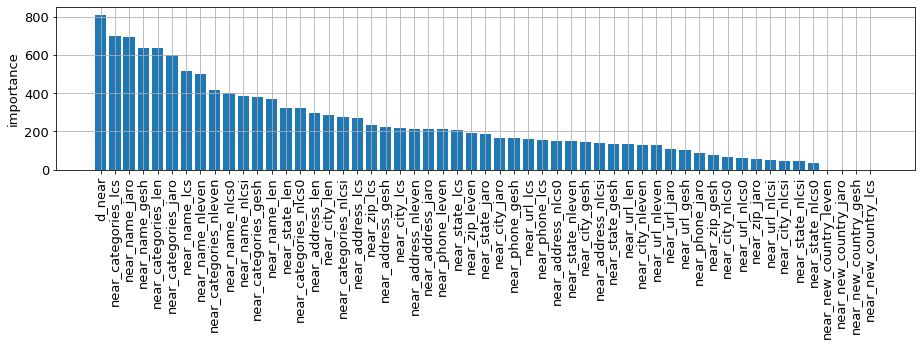

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

# Simple Post-Processing

In [ ]:
import optuna
from copy import deepcopy

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    id2ids = train[train["pred"] > x].groupby('id')['near_id'].apply(lambda x: set(x))
    train["matches"] = train["id"]
    if len(id2ids) > 0:
        train.loc[train["id"].isin(id2ids.keys()), "matches"] += " " + train.loc[train["id"].isin(id2ids.keys()), "id"].map(id2ids).map(lambda x: " ".join(x))
    id2match = dict(zip(train["id"].values, train["matches"].str.split()))

    for match in tqdm(train["matches"]):
        match = match.split()
        if len(match) == 1:
            continue

        base = match[0]
        for m in match[1:]:
            if not base in id2match[m]:
                id2match[m].append(base)
    id2ids = deepcopy(id2match)
    for id, ids in id2ids.items():
        id2ids[id] = set(ids)
    score, precision, recall = get_score(id2ids)
    print(f"CV: {score:.6f}, precision: {precision:.6f}, recall: {recall:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-13 10:48:42,198] A new study created in memory with name: no-name-dd7780ab-629d-4c6a-844d-749e450a5ec9


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 10:49:58,224] Trial 0 finished with value: 0.810556608033448 and parameters: {'threshold': 0.5294579710801011}. Best is trial 0 with value: 0.810556608033448.


CV: 0.810557, precision: 0.955318, recall: 0.848380


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.791967, precision: 0.987935, recall: 0.801979


[I 2022-05-13 10:51:01,198] Trial 1 finished with value: 0.7919674776556412 and parameters: {'threshold': 0.8305249564744562}. Best is trial 0 with value: 0.810556608033448.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 10:52:00,277] Trial 2 finished with value: 0.8035542617561622 and parameters: {'threshold': 0.7390137565630981}. Best is trial 0 with value: 0.810556608033448.


CV: 0.803554, precision: 0.979441, recall: 0.820572


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 10:52:47,057] Trial 3 finished with value: 0.7515046810710879 and parameters: {'threshold': 0.9424152597035047}. Best is trial 0 with value: 0.810556608033448.


CV: 0.751505, precision: 0.996758, recall: 0.754202


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 10:53:39,552] Trial 4 finished with value: 0.7791073093124091 and parameters: {'threshold': 0.8845898102971524}. Best is trial 0 with value: 0.810556608033448.


CV: 0.779107, precision: 0.992394, recall: 0.785425


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 10:54:44,020] Trial 5 finished with value: 0.8092669306359895 and parameters: {'threshold': 0.4670372248763123}. Best is trial 0 with value: 0.810556608033448.


CV: 0.809267, precision: 0.946506, recall: 0.854793


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.786809, precision: 0.990067, recall: 0.795063


[I 2022-05-13 10:55:42,267] Trial 6 finished with value: 0.7868085936363349 and parameters: {'threshold': 0.8557598973284767}. Best is trial 0 with value: 0.810556608033448.


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.801863, precision: 0.925591, recall: 0.865511


[I 2022-05-13 10:56:52,501] Trial 7 finished with value: 0.8018627213504317 and parameters: {'threshold': 0.3475006025886418}. Best is trial 0 with value: 0.810556608033448.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 10:58:08,492] Trial 8 finished with value: 0.7836964956076656 and parameters: {'threshold': 0.2211050469943997}. Best is trial 0 with value: 0.810556608033448.


CV: 0.783696, precision: 0.892272, recall: 0.875904


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 10:59:11,229] Trial 9 finished with value: 0.8103459566277863 and parameters: {'threshold': 0.5114289738250924}. Best is trial 0 with value: 0.810556608033448.


CV: 0.810346, precision: 0.952876, recall: 0.850306


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.436847, precision: 0.463378, recall: 0.900143


[I 2022-05-13 11:01:23,924] Trial 10 finished with value: 0.4368471490801789 and parameters: {'threshold': 0.005419408780372947}. Best is trial 0 with value: 0.810556608033448.


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.809643, precision: 0.967829, recall: 0.836590


[I 2022-05-13 11:02:26,986] Trial 11 finished with value: 0.8096429251341286 and parameters: {'threshold': 0.6305396692363571}. Best is trial 0 with value: 0.810556608033448.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 11:03:29,671] Trial 12 finished with value: 0.8106379436275815 and parameters: {'threshold': 0.5692049824091348}. Best is trial 12 with value: 0.8106379436275815.


CV: 0.810638, precision: 0.960463, recall: 0.843985


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.810270, precision: 0.964068, recall: 0.840494


[I 2022-05-13 11:04:31,377] Trial 13 finished with value: 0.8102696165233888 and parameters: {'threshold': 0.5991645584046845}. Best is trial 12 with value: 0.8106379436275815.


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.800021, precision: 0.921673, recall: 0.867041


[I 2022-05-13 11:05:40,353] Trial 14 finished with value: 0.800021240245158 and parameters: {'threshold': 0.3290879803713846}. Best is trial 12 with value: 0.8106379436275815.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 11:06:41,658] Trial 15 finished with value: 0.8080187768072719 and parameters: {'threshold': 0.6720813481276342}. Best is trial 12 with value: 0.8106379436275815.


CV: 0.808019, precision: 0.972453, recall: 0.830978


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.809374, precision: 0.946987, recall: 0.854477


[I 2022-05-13 11:07:49,006] Trial 16 finished with value: 0.8093744517405785 and parameters: {'threshold': 0.4704293207553508}. Best is trial 12 with value: 0.8106379436275815.


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.795930, precision: 0.913521, recall: 0.869961


[I 2022-05-13 11:08:59,574] Trial 17 finished with value: 0.7959301759957231 and parameters: {'threshold': 0.29367718815296495}. Best is trial 12 with value: 0.8106379436275815.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 11:10:19,145] Trial 18 finished with value: 0.7630409091000026 and parameters: {'threshold': 0.14979726129426563}. Best is trial 12 with value: 0.8106379436275815.


CV: 0.763041, precision: 0.860504, recall: 0.882017


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.810455, precision: 0.953986, recall: 0.849444


[I 2022-05-13 11:11:40,918] Trial 19 finished with value: 0.8104551964759357 and parameters: {'threshold': 0.5195289562538836}. Best is trial 12 with value: 0.8106379436275815.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 11:12:40,705] Trial 20 finished with value: 0.802180739781215 and parameters: {'threshold': 0.754680586109988}. Best is trial 12 with value: 0.8106379436275815.


CV: 0.802181, precision: 0.980986, recall: 0.817901


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 11:13:44,791] Trial 21 finished with value: 0.8107652597386925 and parameters: {'threshold': 0.5475266467624078}. Best is trial 21 with value: 0.8107652597386925.


CV: 0.810765, precision: 0.957788, recall: 0.846430


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 11:14:53,987] Trial 22 finished with value: 0.8057203734113829 and parameters: {'threshold': 0.3955722587808401}. Best is trial 21 with value: 0.8107652597386925.


CV: 0.805720, precision: 0.934831, recall: 0.861391


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.810562, precision: 0.961465, recall: 0.843032


[I 2022-05-13 11:15:58,621] Trial 23 finished with value: 0.8105621754002363 and parameters: {'threshold': 0.5776092595495367}. Best is trial 21 with value: 0.8107652597386925.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 11:16:56,512] Trial 24 finished with value: 0.806291677360956 and parameters: {'threshold': 0.7027459656454911}. Best is trial 21 with value: 0.8107652597386925.


CV: 0.806292, precision: 0.975768, recall: 0.826422


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 11:17:58,121] Trial 25 finished with value: 0.810448342555712 and parameters: {'threshold': 0.5890679214336705}. Best is trial 21 with value: 0.8107652597386925.


CV: 0.810448, precision: 0.962880, recall: 0.841687


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.807591, precision: 0.940466, recall: 0.858389


[I 2022-05-13 11:19:05,781] Trial 26 finished with value: 0.8075911429390825 and parameters: {'threshold': 0.42872958576046916}. Best is trial 21 with value: 0.8107652597386925.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 11:20:08,394] Trial 27 finished with value: 0.8103551818563061 and parameters: {'threshold': 0.5958954412982107}. Best is trial 21 with value: 0.8107652597386925.


CV: 0.810355, precision: 0.963703, recall: 0.840895


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 11:21:07,833] Trial 28 finished with value: 0.8081007611519331 and parameters: {'threshold': 0.6700594425665429}. Best is trial 21 with value: 0.8107652597386925.


CV: 0.808101, precision: 0.972237, recall: 0.831241


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.810755, precision: 0.957997, recall: 0.846233


[I 2022-05-13 11:22:09,719] Trial 29 finished with value: 0.8107545902448516 and parameters: {'threshold': 0.5492295743615468}. Best is trial 21 with value: 0.8107652597386925.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 11:23:10,956] Trial 30 finished with value: 0.800307874355587 and parameters: {'threshold': 0.7722245042300184}. Best is trial 21 with value: 0.8107652597386925.


CV: 0.800308, precision: 0.982659, recall: 0.814631


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 11:24:15,404] Trial 31 finished with value: 0.8106930907917368 and parameters: {'threshold': 0.559386251719138}. Best is trial 21 with value: 0.8107652597386925.


CV: 0.810693, precision: 0.959261, recall: 0.845087


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 11:25:18,472] Trial 32 finished with value: 0.810607877950908 and parameters: {'threshold': 0.5354129360973305}. Best is trial 21 with value: 0.8107652597386925.


CV: 0.810608, precision: 0.956133, recall: 0.847720


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 11:26:24,928] Trial 33 finished with value: 0.8079524777094056 and parameters: {'threshold': 0.4363553050802391}. Best is trial 21 with value: 0.8107652597386925.


CV: 0.807952, precision: 0.941685, recall: 0.857675


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 11:27:29,039] Trial 34 finished with value: 0.8107589544611298 and parameters: {'threshold': 0.5494315816244288}. Best is trial 21 with value: 0.8107652597386925.


CV: 0.810759, precision: 0.958023, recall: 0.846216


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.804196, precision: 0.931019, recall: 0.863178


[I 2022-05-13 11:28:35,885] Trial 35 finished with value: 0.8041963877141124 and parameters: {'threshold': 0.37508281351369843}. Best is trial 21 with value: 0.8107652597386925.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 11:29:14,036] Trial 36 finished with value: 0.6655502546329056 and parameters: {'threshold': 0.9961631464647529}. Best is trial 21 with value: 0.8107652597386925.


CV: 0.665550, precision: 0.999949, recall: 0.665593


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 11:30:13,546] Trial 37 finished with value: 0.7958565721796725 and parameters: {'threshold': 0.806553428948281}. Best is trial 21 with value: 0.8107652597386925.


CV: 0.795857, precision: 0.985787, recall: 0.807618


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 11:31:13,186] Trial 38 finished with value: 0.8090449399266971 and parameters: {'threshold': 0.6486577658526504}. Best is trial 21 with value: 0.8107652597386925.


CV: 0.809045, precision: 0.969884, recall: 0.834209


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 11:32:16,135] Trial 39 finished with value: 0.805276969496507 and parameters: {'threshold': 0.7177355434900987}. Best is trial 21 with value: 0.8107652597386925.


CV: 0.805277, precision: 0.977284, recall: 0.824127


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 11:33:21,684] Trial 40 finished with value: 0.809417053291002 and parameters: {'threshold': 0.4717050316464681}. Best is trial 21 with value: 0.8107652597386925.


CV: 0.809417, precision: 0.947185, recall: 0.854350


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.810539, precision: 0.954940, recall: 0.848689


[I 2022-05-13 11:34:25,736] Trial 41 finished with value: 0.8105386618992174 and parameters: {'threshold': 0.5265627943042772}. Best is trial 21 with value: 0.8107652597386925.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 11:35:26,353] Trial 42 finished with value: 0.8106337121994146 and parameters: {'threshold': 0.5669490356404706}. Best is trial 21 with value: 0.8107652597386925.


CV: 0.810634, precision: 0.960197, recall: 0.844212


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 11:36:29,074] Trial 43 finished with value: 0.8096825432796835 and parameters: {'threshold': 0.6289983635186946}. Best is trial 21 with value: 0.8107652597386925.


CV: 0.809683, precision: 0.967646, recall: 0.836792


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 11:37:32,765] Trial 44 finished with value: 0.8100324051946806 and parameters: {'threshold': 0.49421143894385955}. Best is trial 21 with value: 0.8107652597386925.


CV: 0.810032, precision: 0.950496, recall: 0.852070


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 11:38:36,225] Trial 45 finished with value: 0.8107523672334891 and parameters: {'threshold': 0.54964672438333}. Best is trial 21 with value: 0.8107652597386925.


CV: 0.810752, precision: 0.958045, recall: 0.846193


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.806567, precision: 0.937277, recall: 0.860137


[I 2022-05-13 11:39:42,101] Trial 46 finished with value: 0.806566610239159 and parameters: {'threshold': 0.40986476858667953}. Best is trial 21 with value: 0.8107652597386925.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 11:40:54,322] Trial 47 finished with value: 0.7916155935293252 and parameters: {'threshold': 0.26403172493675037}. Best is trial 21 with value: 0.8107652597386925.


CV: 0.791616, precision: 0.905677, recall: 0.872378


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.810677, precision: 0.957009, recall: 0.847019


[I 2022-05-13 11:41:58,226] Trial 48 finished with value: 0.810677403009025 and parameters: {'threshold': 0.5421050687571716}. Best is trial 21 with value: 0.8107652597386925.


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.808679, precision: 0.944105, recall: 0.856286


[I 2022-05-13 11:43:04,843] Trial 49 finished with value: 0.808678800353535 and parameters: {'threshold': 0.45153864903013674}. Best is trial 21 with value: 0.8107652597386925.


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.809804, precision: 0.966818, recall: 0.837632


[I 2022-05-13 11:44:06,216] Trial 50 finished with value: 0.8098042857769808 and parameters: {'threshold': 0.6221573931687301}. Best is trial 21 with value: 0.8107652597386925.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 11:45:11,392] Trial 51 finished with value: 0.810710459638393 and parameters: {'threshold': 0.5448883937561867}. Best is trial 21 with value: 0.8107652597386925.


CV: 0.810710, precision: 0.957415, recall: 0.846695


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 11:46:15,758] Trial 52 finished with value: 0.809819438214569 and parameters: {'threshold': 0.4882062611203441}. Best is trial 21 with value: 0.8107652597386925.


CV: 0.809819, precision: 0.949594, recall: 0.852648


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 11:47:13,645] Trial 53 finished with value: 0.8073188810449594 and parameters: {'threshold': 0.6852092409057633}. Best is trial 21 with value: 0.8107652597386925.


CV: 0.807319, precision: 0.973895, recall: 0.829045


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 11:48:16,018] Trial 54 finished with value: 0.8107634891046339 and parameters: {'threshold': 0.5531665087655651}. Best is trial 21 with value: 0.8107652597386925.


CV: 0.810763, precision: 0.958487, recall: 0.845821


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.810305, precision: 0.952254, recall: 0.850805


[I 2022-05-13 11:49:18,955] Trial 55 finished with value: 0.8103052780676981 and parameters: {'threshold': 0.5066817929936254}. Best is trial 21 with value: 0.8107652597386925.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 11:50:21,340] Trial 56 finished with value: 0.8097170050416903 and parameters: {'threshold': 0.6269206417070715}. Best is trial 21 with value: 0.8107652597386925.


CV: 0.809717, precision: 0.967397, recall: 0.837039


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.800669, precision: 0.923072, recall: 0.866488


[I 2022-05-13 11:51:30,593] Trial 57 finished with value: 0.8006691324284553 and parameters: {'threshold': 0.33557946722561843}. Best is trial 21 with value: 0.8107652597386925.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 11:52:30,407] Trial 58 finished with value: 0.8101776560340685 and parameters: {'threshold': 0.6045931029027647}. Best is trial 21 with value: 0.8107652597386925.


CV: 0.810178, precision: 0.964741, recall: 0.839819


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 11:53:38,566] Trial 59 finished with value: 0.8040261492691873 and parameters: {'threshold': 0.37280726809913833}. Best is trial 21 with value: 0.8107652597386925.


CV: 0.804026, precision: 0.930614, recall: 0.863347


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 11:54:39,018] Trial 60 finished with value: 0.8084597418842978 and parameters: {'threshold': 0.6622308826969329}. Best is trial 21 with value: 0.8107652597386925.


CV: 0.808460, precision: 0.971392, recall: 0.832327


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 11:55:41,112] Trial 61 finished with value: 0.8107521764220346 and parameters: {'threshold': 0.5540775134475385}. Best is trial 21 with value: 0.8107652597386925.


CV: 0.810752, precision: 0.958588, recall: 0.845720


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 11:56:44,233] Trial 62 finished with value: 0.8107190617826928 and parameters: {'threshold': 0.5556725023872757}. Best is trial 21 with value: 0.8107652597386925.


CV: 0.810719, precision: 0.958781, recall: 0.845525


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.809178, precision: 0.946199, recall: 0.854973


[I 2022-05-13 11:57:50,873] Trial 63 finished with value: 0.8091780023434627 and parameters: {'threshold': 0.46512987748899104}. Best is trial 21 with value: 0.8107652597386925.


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.810244, precision: 0.951891, recall: 0.851056


[I 2022-05-13 11:58:55,296] Trial 64 finished with value: 0.8102440238067957 and parameters: {'threshold': 0.5040505410555489}. Best is trial 21 with value: 0.8107652597386925.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 11:59:58,539] Trial 65 finished with value: 0.8105558757611236 and parameters: {'threshold': 0.5799797216627535}. Best is trial 21 with value: 0.8107652597386925.


CV: 0.810556, precision: 0.961747, recall: 0.842779


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 12:00:57,019] Trial 66 finished with value: 0.8048900989581528 and parameters: {'threshold': 0.7224907870776445}. Best is trial 21 with value: 0.8107652597386925.


CV: 0.804890, precision: 0.977769, recall: 0.823330


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.810775, precision: 0.958407, recall: 0.845904


[I 2022-05-13 12:02:00,562] Trial 67 finished with value: 0.8107754969482527 and parameters: {'threshold': 0.5524457174976896}. Best is trial 67 with value: 0.8107754969482527.


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.810155, precision: 0.964972, recall: 0.839597


[I 2022-05-13 12:03:03,230] Trial 68 finished with value: 0.8101554558268786 and parameters: {'threshold': 0.6064828169544985}. Best is trial 67 with value: 0.8107754969482527.


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.807269, precision: 0.939421, recall: 0.858970


[I 2022-05-13 12:04:09,834] Trial 69 finished with value: 0.8072690191920648 and parameters: {'threshold': 0.4224951122377343}. Best is trial 67 with value: 0.8107754969482527.


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.809176, precision: 0.969441, recall: 0.834720


[I 2022-05-13 12:05:09,418] Trial 70 finished with value: 0.8091755509669819 and parameters: {'threshold': 0.6449133954389386}. Best is trial 67 with value: 0.8107754969482527.


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.810703, precision: 0.959131, recall: 0.845210


[I 2022-05-13 12:06:13,111] Trial 71 finished with value: 0.8107031759396506 and parameters: {'threshold': 0.5583920510324576}. Best is trial 67 with value: 0.8107754969482527.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 12:07:17,626] Trial 72 finished with value: 0.8104992674331508 and parameters: {'threshold': 0.5236668504453411}. Best is trial 67 with value: 0.8107754969482527.


CV: 0.810499, precision: 0.954546, recall: 0.848998


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 12:09:05,666] Trial 73 finished with value: 0.5895168388354458 and parameters: {'threshold': 0.01859818517692674}. Best is trial 67 with value: 0.8107754969482527.


CV: 0.589517, precision: 0.637950, recall: 0.896964


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 12:10:08,562] Trial 74 finished with value: 0.8105390985071093 and parameters: {'threshold': 0.5810671101965352}. Best is trial 67 with value: 0.8107754969482527.


CV: 0.810539, precision: 0.961873, recall: 0.842651


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.808751, precision: 0.944402, recall: 0.856102


[I 2022-05-13 12:11:13,643] Trial 75 finished with value: 0.8087513936886819 and parameters: {'threshold': 0.45328613905876536}. Best is trial 67 with value: 0.8107754969482527.


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.809650, precision: 0.948455, recall: 0.853479


[I 2022-05-13 12:12:22,013] Trial 76 finished with value: 0.8096501276345641 and parameters: {'threshold': 0.4803627718139468}. Best is trial 67 with value: 0.8107754969482527.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 12:13:24,386] Trial 77 finished with value: 0.8107578984870017 and parameters: {'threshold': 0.5488180997201876}. Best is trial 67 with value: 0.8107754969482527.


CV: 0.810758, precision: 0.957949, recall: 0.846282


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.810266, precision: 0.964169, recall: 0.840401


[I 2022-05-13 12:14:26,191] Trial 78 finished with value: 0.8102656548542279 and parameters: {'threshold': 0.5998888195415006}. Best is trial 67 with value: 0.8107754969482527.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 12:15:25,341] Trial 79 finished with value: 0.8070164503817743 and parameters: {'threshold': 0.6900367045412064}. Best is trial 67 with value: 0.8107754969482527.


CV: 0.807016, precision: 0.974411, recall: 0.828307


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 12:16:30,649] Trial 80 finished with value: 0.8104918549307126 and parameters: {'threshold': 0.5232006426379296}. Best is trial 67 with value: 0.8107754969482527.


CV: 0.810492, precision: 0.954483, recall: 0.849046


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 12:17:33,769] Trial 81 finished with value: 0.8107542590533051 and parameters: {'threshold': 0.5491403075579683}. Best is trial 67 with value: 0.8107754969482527.


CV: 0.810754, precision: 0.957988, recall: 0.846242


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 12:18:48,260] Trial 82 finished with value: 0.8101652938148506 and parameters: {'threshold': 0.4996070720396384}. Best is trial 67 with value: 0.8107754969482527.


CV: 0.810165, precision: 0.951260, recall: 0.851522


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 12:19:56,564] Trial 83 finished with value: 0.8107779389568663 and parameters: {'threshold': 0.5520418343599458}. Best is trial 83 with value: 0.8107779389568663.


CV: 0.810778, precision: 0.958359, recall: 0.845948


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 12:20:59,795] Trial 84 finished with value: 0.8105752870687013 and parameters: {'threshold': 0.5320659727821915}. Best is trial 83 with value: 0.8107779389568663.


CV: 0.810575, precision: 0.955676, recall: 0.848083


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 12:22:02,958] Trial 85 finished with value: 0.8105632724350258 and parameters: {'threshold': 0.5771358297716244}. Best is trial 83 with value: 0.8107779389568663.


CV: 0.810563, precision: 0.961404, recall: 0.843087


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 12:23:03,614] Trial 86 finished with value: 0.8093187425134281 and parameters: {'threshold': 0.6405131403957354}. Best is trial 83 with value: 0.8107779389568663.


CV: 0.809319, precision: 0.968936, recall: 0.835302


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 12:24:11,141] Trial 87 finished with value: 0.8079118873410511 and parameters: {'threshold': 0.4355871187058491}. Best is trial 83 with value: 0.8107779389568663.


CV: 0.807912, precision: 0.941557, recall: 0.857748


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 12:25:13,455] Trial 88 finished with value: 0.8100857238220363 and parameters: {'threshold': 0.6107639747722421}. Best is trial 83 with value: 0.8107779389568663.


CV: 0.810086, precision: 0.965488, recall: 0.839075


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 12:26:20,624] Trial 89 finished with value: 0.8103864112776547 and parameters: {'threshold': 0.5133378268392595}. Best is trial 83 with value: 0.8107779389568663.


CV: 0.810386, precision: 0.953157, recall: 0.850097


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 12:27:25,725] Trial 90 finished with value: 0.809646209910733 and parameters: {'threshold': 0.4810546262294852}. Best is trial 83 with value: 0.8107779389568663.


CV: 0.809646, precision: 0.948543, recall: 0.853399


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.810731, precision: 0.958710, recall: 0.845597


[I 2022-05-13 12:28:30,403] Trial 91 finished with value: 0.8107305064754968 and parameters: {'threshold': 0.5550912088718516}. Best is trial 83 with value: 0.8107779389568663.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 12:29:34,650] Trial 92 finished with value: 0.8106664915090885 and parameters: {'threshold': 0.5416741084416729}. Best is trial 83 with value: 0.8107779389568663.


CV: 0.810666, precision: 0.956952, recall: 0.847055


  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.810468, precision: 0.962341, recall: 0.842171


[I 2022-05-13 12:30:37,933] Trial 93 finished with value: 0.8104676795758109 and parameters: {'threshold': 0.5849956588384142}. Best is trial 83 with value: 0.8107779389568663.


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 12:31:39,180] Trial 94 finished with value: 0.8085145112978344 and parameters: {'threshold': 0.6610399913161132}. Best is trial 83 with value: 0.8107779389568663.


CV: 0.808515, precision: 0.971259, recall: 0.832496


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 12:32:41,590] Trial 95 finished with value: 0.8106858654728685 and parameters: {'threshold': 0.5631294833172916}. Best is trial 83 with value: 0.8107779389568663.


CV: 0.810686, precision: 0.959723, recall: 0.844678


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 12:33:49,620] Trial 96 finished with value: 0.8088214304709362 and parameters: {'threshold': 0.4557473063236612}. Best is trial 83 with value: 0.8107779389568663.


CV: 0.808821, precision: 0.944746, recall: 0.855870


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 12:34:55,498] Trial 97 finished with value: 0.8101634876751866 and parameters: {'threshold': 0.49976101558406005}. Best is trial 83 with value: 0.8107779389568663.


CV: 0.810163, precision: 0.951280, recall: 0.851504


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 12:36:04,466] Trial 98 finished with value: 0.8058190630500028 and parameters: {'threshold': 0.39723514383479414}. Best is trial 83 with value: 0.8107779389568663.


CV: 0.805819, precision: 0.935126, recall: 0.861237


  0%|          | 0/10250452 [00:00<?, ?it/s]

[I 2022-05-13 12:37:08,000] Trial 99 finished with value: 0.8106207952988372 and parameters: {'threshold': 0.5392073129027044}. Best is trial 83 with value: 0.8107779389568663.


CV: 0.810621, precision: 0.956619, recall: 0.847299


In [ ]:
threshold = study.best_params['threshold']
threshold

0.5520418343599458

In [ ]:
study.best_value

0.8107779389568663

In [ ]:
id2ids = train[train["pred"] > threshold].groupby('id')['near_id'].apply(lambda x: set(x))
train["matches"] = train["id"]
if len(id2ids) > 0:
    train.loc[train["id"].isin(id2ids.keys()), "matches"] += " " + train.loc[train["id"].isin(id2ids.keys()), "id"].map(id2ids).map(lambda x: " ".join(x))
id2match = dict(zip(train["id"].values, train["matches"].str.split()))

for match in tqdm(train["matches"]):
    match = match.split()
    if len(match) == 1:
        continue

    base = match[0]
    for m in match[1:]:
        if not base in id2match[m]:
            id2match[m].append(base)
id2ids = deepcopy(id2match)
for id, ids in id2ids.items():
    id2ids[id] = set(ids)
score, precision, recall = get_score(id2ids)
print(f"CV: {score:.6f}, precision: {precision:.6f}, recall: {recall:.6f}")

  0%|          | 0/10250452 [00:00<?, ?it/s]

CV: 0.810778, precision: 0.958359, recall: 0.845948


# Submit

In [ ]:
test["pred"] = pred[:, 1]

In [ ]:
ssub = pd.read_csv("../Input/sample_submission.csv")
ssub = ssub.drop(columns="matches")
id2ids = test[test["pred"] > threshold].groupby('id')['near_id'].apply(lambda x: set(x))
ssub["matches"] = ssub["id"]
if len(id2ids) > 0:
    ssub.loc[ssub["id"].isin(id2ids.keys()), "matches"] += " " + ssub.loc[ssub["id"].isin(id2ids.keys()), "id"].map(id2ids).map(lambda x: " ".join(x))
id2match = dict(zip(ssub["id"].values, ssub["matches"].str.split()))

for match in tqdm(ssub["matches"]):
    match = match.split()
    if len(match) == 1:
        continue

    base = match[0]
    for m in match[1:]:
        if not base in id2match[m]:
            id2match[m].append(base)

ssub["matches"] = ssub["id"].map(id2match).map(lambda x: " ".join(x))
ssub.to_csv(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "submission.csv")), index=False)

ssub.head()

  0%|          | 0/5 [00:00<?, ?it/s]

,id,matches
0,E_00001118ad0191,E_00001118ad0191
1,E_000020eb6fed40,E_000020eb6fed40
2,E_00002f98667edf,E_00002f98667edf
3,E_001b6bad66eb98,E_001b6bad66eb98 E_0283d9f61e569d
4,E_0283d9f61e569d,E_0283d9f61e569d E_001b6bad66eb98
